## Preprocessing and Mapping: date munging, data partitioning, handle missing values, encode categorical variables, scale, normalize

In [471]:
### Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import date
from datetime import time
from datetime import datetime

import seaborn as sns #charts
sns.set()

import folium #mapping
SF_COORDINATES = (37.76, -122.45)

In [472]:
df = pd.read_csv('/home/ec2-user/SageMaker/df_location_master_final.csv', sep = ',', parse_dates=True) #, index_col = 'business_id'  
df.drop(columns = 'Unnamed: 0', inplace = True)
df.head(3)

# I have to drop the column because of how I saved the master data set 

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,neighborhood,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category
0,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,11/29/2017 12:00:00 AM,83.0,Routine - Unscheduled,852_20171129_103139,Improper food storage,Low Risk
1,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,11/29/2017 12:00:00 AM,83.0,Routine - Unscheduled,852_20171129_103156,Permit license or inspection report not posted,Low Risk
2,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,11/29/2017 12:00:00 AM,83.0,Routine - Unscheduled,852_20171129_103144,Unapproved or unmaintained equipment or utensils,Low Risk


In [473]:
#df['business_id'].unique()

In [474]:
print('Total Number of Records:', len(df['business_id']))
# Number of unique businesses
print('Unique Biz:', len(df['business_id'].unique()))

#The data set is at a violation id level therefore equivalent to the number of records.

Total Number of Records: 48765
Unique Biz: 5396


### I need to learn more about the data set. I think the best way to do this is via series of maps and charts.

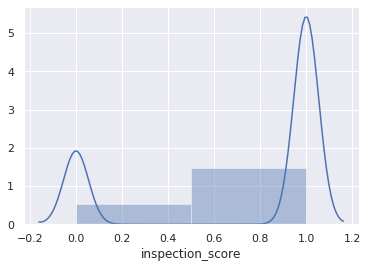

In [475]:
# First lets check the distribution plot of the inspections_score. This after all is currently the top predictor
sns.distplot(df['inspection_score'].notnull(),hist=True,bins=2)
#Score is generally over 50% in the data set. If we measured the scores on a likert scale this would have been a nice graph 
# However, considering anything but a health inspection score 90 makes the restaurant choices pretty slim.

## Inspection details

In [476]:
df['inspection_type'].value_counts()

Routine - Unscheduled                36122
Reinspection/Followup                 6201
Complaint                             2256
New Ownership                         1544
New Construction                       811
Non-inspection site visit              759
New Ownership - Followup               400
Complaint Reinspection/Followup        221
Structural Inspection                  209
Foodborne Illness Investigation        185
Routine - Scheduled                     45
Special Event                            6
Multi-agency Investigation               3
Administrative or Document Review        2
Community Health Assessment              1
Name: inspection_type, dtype: int64

### SF Department of Health mentions on their website that a food facility can be inspected for several reasosn. The first reason is routine - unscheduled inspections which is confirmed by the the highest number in the data set. Reinspection/Followup is for the specific purpose of re-inspecting items that were not in compliance at the time of the routine inspection. These may occur either 5-days or 1- days after the initial findings. So reinspection/followup is a product of Routine - Unscheduled inspection. This means 1 in very 6 inspections a reinspection was necessary. I think it is safe to say that the inspector is not going to come back to check a low risk item. Discouraging. 

### Other high numbers are Complaints and New Ownerships / New Construction. Perhaps it would be possible to recategorize these to their similarity and lower the possible number of inspection types. It looks like:
- Routine = "Routine - Unscheduled" and "Reinspection/Followup"
- New = "New Ownership" and "New Construction" and "New Ownership - Followup" and "Structural Inspection" and - "Non-inspection site visit" and Routine - Scheduled" and "Special Event" and "Multi-agency Investigation" and "Administrative or Document Review" and "Community Health Assessment" (This is mostly permits, and these days permits to operate outdoors.)
- Complaint = "Complaint" and "Complaint Reinspection/Followup" and "Foodborne Illness Investigation"

- Routine inspections (mantated by SF Health), New inspections (mantated by SF Health) and Complaints (initiated by public)
- In addition it will be possible to analyze within only 2 categories. "Initiated by Public" and "Mandated by SFDPH" (SF - Department of Public Health) (After working with teh data set it makes more sense to only use Routine - Unscheduled inspection type for the feature set.

In [477]:
df.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,neighborhood,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category
0,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,11/29/2017 12:00:00 AM,83.0,Routine - Unscheduled,852_20171129_103139,Improper food storage,Low Risk
1,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,11/29/2017 12:00:00 AM,83.0,Routine - Unscheduled,852_20171129_103156,Permit license or inspection report not posted,Low Risk
2,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,11/29/2017 12:00:00 AM,83.0,Routine - Unscheduled,852_20171129_103144,Unapproved or unmaintained equipment or utensils,Low Risk
3,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171207,12/07/2017 12:00:00 AM,NaN,Reinspection/Followup,NaN,NaN,NaN
4,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,11/29/2017 12:00:00 AM,83.0,Routine - Unscheduled,852_20171129_103149,Wiping cloths not clean or properly stored or ...,Low Risk


# On their website SF-DPH claims that food establishments are visited at a minimum of two times a year. These are Routine - Unscheduled visits. I would like to confirm. But first I need to update the data type to date time.

In [478]:
print(df['inspection_date'].dtypes)
df['inspection_date']= pd.to_datetime(df['inspection_date'])
print(df['inspection_date'].dtypes)

object
datetime64[ns]


In [479]:
df.columns

Index(['business_id', 'business_name', 'business_address', 'business_city',
       'business_state', 'business_postal_code', 'business_latitude',
       'business_longitude', 'neighborhood', 'inspection_id',
       'inspection_date', 'inspection_score', 'inspection_type',
       'violation_id', 'violation_description', 'risk_category'],
      dtype='object')

In [480]:
# New smaller data set just for inspection information
df_inspection = df[['business_id', 'business_name', 'business_postal_code', 'business_latitude',
       'business_longitude', 'neighborhood','inspection_date', 'inspection_type', 'inspection_score']]
df_inspection.head(3)

,business_id,business_name,business_postal_code,business_latitude,business_longitude,neighborhood,inspection_date,inspection_type,inspection_score
0,852,New Hollywood Bakery & Restaurant,94133,37.797083,-122.406057,North Beach/Chinatown,2017-11-29,Routine - Unscheduled,83.0
1,852,New Hollywood Bakery & Restaurant,94133,37.797083,-122.406057,North Beach/Chinatown,2017-11-29,Routine - Unscheduled,83.0
2,852,New Hollywood Bakery & Restaurant,94133,37.797083,-122.406057,North Beach/Chinatown,2017-11-29,Routine - Unscheduled,83.0


In [481]:
# Hall of Fame - Business with top scores
df_inspection['business_name'][df['inspection_score'] == 100.0].unique().tolist()[20:30]

['The Hummus Guy',
 'Home Maid Ravioli Co.',
 'Phoenix Pastificio',
 'FlourChylde Bakery',
 'MV Scorpio',
 'Walgreens #1126',
 'Bluxome Street Winery',
 'Sushi Avenue Inc',
 'Ghirardelli Chocolate - Main Concourse Level',
 'Kettle Corn Star']

In [482]:
# Above list shows businesses that received a 100 at one point in time. That is nice but what I truly would like to know is the all stars
# below code returns the mean of the inspection score. 
df_inspection_mean = df_inspection.groupby('business_name').mean().sort_values(by='inspection_score', ascending=False)
df_inspection_mean = df_inspection_mean.reset_index()
df_inspection_mean.head()

#Very important lesson here, Index must be reset once grouping and the calculation are completed. I spend good time figuring out the map.

,business_name,business_id,business_postal_code,business_latitude,business_longitude,inspection_score
0,"#1 VERJUS CAVE, #2 VERJUS",98806.0,94111.0,37.795714,-122.402699,100.0
1,OKINA SUSHI,1188.0,94118.0,37.775723,-122.458445,100.0
2,"MEALS ON WHEELS OF SF, INC.",5213.0,94124.0,37.739891,-122.384800,100.0
3,MISSION PICNIC,98890.0,94110.0,37.757316,-122.421017,100.0
4,MV Scorpio,68262.0,94133.0,37.809474,-122.411851,100.0


In [483]:
# Here I filter for All Stars only the best of the best - restaurants with a mean score of 100. 
# Considering how small the dataset is this means never had a single nick
#df_inspection_mean['business_name'][df_inspection_mean['inspection_score'] == 100.0]
best = df_inspection_mean[df_inspection_mean['inspection_score'] == 100.0]
best = best.reset_index()
best.head(5)

,index,business_name,business_id,business_postal_code,business_latitude,business_longitude,inspection_score
0,0,"#1 VERJUS CAVE, #2 VERJUS",98806.0,94111.0,37.795714,-122.402699,100.0
1,1,OKINA SUSHI,1188.0,94118.0,37.775723,-122.458445,100.0
2,2,"MEALS ON WHEELS OF SF, INC.",5213.0,94124.0,37.739891,-122.384800,100.0
3,3,MISSION PICNIC,98890.0,94110.0,37.757316,-122.421017,100.0
4,4,MV Scorpio,68262.0,94133.0,37.809474,-122.411851,100.0


In [484]:
# I consider anything around 70 to be deplorable. Since this is the mean, it shows repetable offenders and should be avoided at all cost.
worst=df_inspection_mean[df_inspection_mean['inspection_score'] < 75.0]
worst = worst.reset_index()
worst.head(3)

,index,business_name,business_id,business_postal_code,business_latitude,business_longitude,inspection_score
0,4469,Hong Kee & Kim,69962.0,94111.0,37.794354,-122.396729,74.923077
1,4470,ADELITA'S CAKES,386.0,94110.0,37.736304,-122.424432,74.857143
2,4471,NoodleMe,87551.0,94105.0,37.791938,-122.397404,74.857143


### Best and Worst of SF

In [485]:
# create empty map zoomed in on San Francisco
map_best = folium.Map(location=SF_COORDINATES, zoom_start=12) 
map_worst = folium.Map(location=SF_COORDINATES, zoom_start=12) 

In [486]:
## Mapping by using lambda
map = folium.Map(location=SF_COORDINATES, zoom_start=12) 
# best.apply(lambda row:folium.Marker(location=[row["business_latitude"], row["business_longitude"]]).add_to(map), axis=1)
# map

In [487]:
MAX_RECORDS = 3500 #limit for cosmetics
# add a marker for every record in the filtered data, use a clustered view
for each in best[0:MAX_RECORDS].iterrows():
    folium.Marker([each[1]["business_latitude"],each[1]["business_longitude"]],
        popup=each[1]["business_name"]).add_to(map_best)
map_best

In [488]:
# Number of inspections to show.  
worst["inspection_score"]=worst["inspection_score"].astype(str)

In [489]:
MAX_RECORDS = 3500 #limit for cosmetics
# add a marker for every record in the filtered data, use a clustered view
for each in worst[0:MAX_RECORDS].iterrows():
    folium.Marker([each[1]["business_latitude"],each[1]["business_longitude"]],
        popup=each[1]["business_name"]+ " Inspection Score: " + each[1]["inspection_score"]).add_to(map_worst)
map_worst

In [490]:
#df_inspectionv2=df.dropna(subset=['inspection_score'])  #confirming nans are included in the .agg() - They are!

# Feature selection / creation: In this data set readily available feature is only one and that is the inspections score however there is valueable information and additional features can be derived to build a data set. First thing to decide is the granulity. At what level should I be slicing data. First I will start from the higher view of nieighboorhoods.

### At Neighborhood level

In [491]:

df_grouped_neigh_zip = df.groupby(['neighborhood']).agg({'inspection_score': ['median','mean', 'min', 'count']})
df_grouped_neigh_zip.columns = ['inspection_score_median','inspection_score_mean', 'inspection_score_min', 'number_of_inspections']
df_grouped_neigh_zip = df_grouped_neigh_zip.reset_index()
df_grouped_neigh_zip=df_grouped_neigh_zip.sort_values('neighborhood')
df_grouped_neigh_zip

,neighborhood,inspection_score_median,inspection_score_mean,inspection_score_min,number_of_inspections
0,75 Howard Area,88.0,87.473090,68.0,1152
1,Bayview-Hunters Point,88.0,85.547866,57.0,867
2,Castro/Noe Valley,88.0,88.421101,69.0,1090
3,Chinatown,86.0,84.494744,55.0,1522
4,East Cut,87.0,85.996850,62.0,1270
5,Haight-Ashbury,88.0,87.194444,62.0,936
6,Hayes Valley/Tenderloin/North of Market,88.0,86.423768,55.0,2617
7,Ingelside-Excelsior/Crocker-Amazon,86.0,84.983755,65.0,1662
8,Inner Mission/Bernal Heights,87.0,85.995246,57.0,4417
9,Inner Richmond,85.0,83.940945,48.0,2032


In [492]:
df_grouped_neigh_zip.sort_values(['number_of_inspections', 'inspection_score_mean'], ascending=[0, 1])

,neighborhood,inspection_score_median,inspection_score_mean,inspection_score_min,number_of_inspections
8,Inner Mission/Bernal Heights,87.0,85.995246,57.0,4417
18,South of Market,88.0,86.207713,46.0,2956
16,Polk/Russian Hill (Nob Hill),87.0,85.617053,59.0,2674
6,Hayes Valley/Tenderloin/North of Market,88.0,86.423768,55.0,2617
13,North Beach/Chinatown,88.0,86.946028,58.0,2316
9,Inner Richmond,85.0,83.940945,48.0,2032
7,Ingelside-Excelsior/Crocker-Amazon,86.0,84.983755,65.0,1662
20,Sunset,86.0,85.222291,57.0,1624
3,Chinatown,86.0,84.494744,55.0,1522
14,Outer Richmond,85.0,84.255878,63.0,1446


In [493]:
number_of_biz = df.groupby(['neighborhood']).business_id.nunique()
number_of_biz=pd.DataFrame(number_of_biz)
number_of_biz = number_of_biz.reset_index()

# number_of_biz
result = pd.concat([df_grouped_neigh_zip, number_of_biz['business_id']], axis=1)
result=result.rename(columns={"business_id": "number_of_businesses"})

frequency_of_inspections_per_neighboorhood = pd.DataFrame(result['number_of_inspections'] / result['number_of_businesses'])
frequency_of_inspections_per_neighboorhood=frequency_of_inspections_per_neighboorhood[0]
df_grouped_neigh_zip=pd.concat([result, frequency_of_inspections_per_neighboorhood], axis=1)
df_grouped_neigh_zip

# Neighboorhood level info is great and it gives me a good idea on the features I need however 
# I need more granular data and inthis case inspection level data. Also I can look at inspections scores in an Alphabetical way.

,neighborhood,inspection_score_median,inspection_score_mean,inspection_score_min,number_of_inspections,number_of_businesses,0
0,75 Howard Area,88.0,87.473090,68.0,1152,225,5.120000
1,Bayview-Hunters Point,88.0,85.547866,57.0,867,179,4.843575
2,Castro/Noe Valley,88.0,88.421101,69.0,1090,194,5.618557
3,Chinatown,86.0,84.494744,55.0,1522,217,7.013825
4,East Cut,87.0,85.996850,62.0,1270,192,6.614583
5,Haight-Ashbury,88.0,87.194444,62.0,936,189,4.952381
6,Hayes Valley/Tenderloin/North of Market,88.0,86.423768,55.0,2617,437,5.988558
7,Ingelside-Excelsior/Crocker-Amazon,86.0,84.983755,65.0,1662,189,8.793651
8,Inner Mission/Bernal Heights,87.0,85.995246,57.0,4417,545,8.104587
9,Inner Richmond,85.0,83.940945,48.0,2032,222,9.153153


In [494]:
# pd_df['difficulty'] = np.select(
#     [
#         pd_df['Time'].between(0, 30, inclusive=False), 
#         pd_df['Time'].between(30, 60, inclusive=True)
#     ], 
#     [
#         'Easy', 
#         'Medium'
#     ], 
#     default='Unknown'
# )

### Per inspection visit level

In [495]:
df_grouped_inspection_raw = df[df['inspection_type'] == 'Routine - Unscheduled']

In [496]:
df_grouped_inspection = df_grouped_inspection_raw.groupby(['inspection_id']).agg({'inspection_score': ['median','mean', 'min', 'count']})
df_grouped_inspection.columns = ['inspection_score_median','inspection_score_mean', 'inspection_score_min', 'number_of_violations_per_visit']
df_grouped_inspection = df_grouped_inspection.reset_index()
df_grouped_inspection=df_grouped_inspection.sort_values('inspection_id')
df_grouped_inspection

,inspection_id,inspection_score_median,inspection_score_mean,inspection_score_min,number_of_violations_per_visit
0,100041_20190520,83.0,83.0,83.0,4
1,100059_20190815,76.0,76.0,76.0,5
2,100069_20190906,100.0,100.0,100.0,1
3,100072_20190326,89.0,89.0,89.0,2
4,100083_20190717,92.0,92.0,92.0,2
...,...,...,...,...,...
12473,999_20170714,77.0,77.0,77.0,6
12474,999_20180123,80.0,80.0,80.0,7
12475,999_20190909,80.0,80.0,80.0,6
12476,99_20171207,82.0,82.0,82.0,6


In [497]:
df_grouped_inspection_raw['risk_category']=df_grouped_inspection_raw['risk_category'].fillna('No Risk')
df_grouped_inspection_raw.head(3)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,neighborhood,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category
0,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,2017-11-29,83.0,Routine - Unscheduled,852_20171129_103139,Improper food storage,Low Risk
1,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,2017-11-29,83.0,Routine - Unscheduled,852_20171129_103156,Permit license or inspection report not posted,Low Risk
2,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,2017-11-29,83.0,Routine - Unscheduled,852_20171129_103144,Unapproved or unmaintained equipment or utensils,Low Risk


In [498]:
df_grouped_inspection_risk=df_grouped_inspection_raw.groupby(['inspection_id','risk_category']).size().unstack(fill_value=0)

# I think number of violations is also a good indicator. 
df_grouped_inspection_risk['number_of_violations_per_visit'] = df_grouped_inspection_risk['High Risk']+df_grouped_inspection_risk['Low Risk']+df_grouped_inspection_risk['Moderate Risk']+df_grouped_inspection_risk['No Risk']
df_grouped_inspection_risk

risk_category,High Risk,Low Risk,Moderate Risk,No Risk,number_of_violations_per_visit
inspection_id,,,,,
100041_20190520,1,1,2,0,4
100059_20190815,2,1,2,0,5
100069_20190906,0,0,0,1,1
100072_20190326,1,0,1,0,2
100083_20190717,0,0,2,0,2
...,...,...,...,...,...
999_20170714,1,2,3,0,6
999_20180123,0,4,3,0,7
999_20190909,0,2,4,0,6


### By Business Level - This one looks just right. Afterall we would like to infer results at the business level for th einspector!

In [499]:
df_grouped_inspection_raw = df[df['inspection_type'] == 'Routine - Unscheduled']

In [500]:
df_grouped_inspection_raw['risk_category']=df_grouped_inspection_raw['risk_category'].fillna('No Risk')
df_grouped_inspection_raw.head(3)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,neighborhood,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category
0,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,2017-11-29,83.0,Routine - Unscheduled,852_20171129_103139,Improper food storage,Low Risk
1,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,2017-11-29,83.0,Routine - Unscheduled,852_20171129_103156,Permit license or inspection report not posted,Low Risk
2,852,New Hollywood Bakery & Restaurant,652 Pacific Ave,San Francisco,CA,94133,37.797083,-122.406057,North Beach/Chinatown,852_20171129,2017-11-29,83.0,Routine - Unscheduled,852_20171129_103144,Unapproved or unmaintained equipment or utensils,Low Risk


In [501]:
df_grouped_inspection = df_grouped_inspection_raw.groupby(['business_id']).agg({'inspection_score': ['median','mean', 'min']})
df_grouped_inspection.columns = ['inspection_score_median','inspection_score_mean', 'inspection_score_min']
df_grouped_inspection = df_grouped_inspection.reset_index()
df_grouped_inspection=df_grouped_inspection.sort_values('business_id')
df_grouped_inspection

,business_id,inspection_score_median,inspection_score_mean,inspection_score_min
0,19,94.0,94.666667,94.0
1,24,98.0,98.000000,98.0
2,31,95.0,95.000000,94.0
3,45,88.0,88.000000,85.0
4,48,87.0,89.800000,87.0
...,...,...,...,...
4996,101838,87.0,87.000000,87.0
4997,101853,100.0,100.000000,100.0
4998,102257,94.0,94.000000,94.0
4999,102336,82.0,82.000000,82.0


In [502]:
#number of violations per business
df_grouped_businessid_risk=df_grouped_inspection_raw.groupby(['business_id','risk_category']).size().unstack(fill_value=0)

# I think number of violations is also a good indicator. 
df_grouped_businessid_risk['total_number_of_violations'] = df_grouped_businessid_risk['High Risk']+df_grouped_businessid_risk['Low Risk']+df_grouped_businessid_risk['Moderate Risk']+df_grouped_businessid_risk['No Risk']
df_grouped_businessid_risk

risk_category,High Risk,Low Risk,Moderate Risk,No Risk,total_number_of_violations
business_id,,,,,
19,0,1,2,0,3
24,0,2,0,1,3
31,0,3,1,0,4
45,1,12,4,0,17
48,1,2,2,0,5
...,...,...,...,...,...
101838,1,3,0,0,4
101853,0,0,0,1,1
102257,0,1,1,0,2


In [503]:
#df_grouped_inspection, df_grouped_businessid_risk
# Merge two dfs together
df_features_business=pd.merge(df_grouped_inspection, df_grouped_businessid_risk, on='business_id', how='inner')
df_features_business

,business_id,inspection_score_median,inspection_score_mean,inspection_score_min,High Risk,Low Risk,Moderate Risk,No Risk,total_number_of_violations
0,19,94.0,94.666667,94.0,0,1,2,0,3
1,24,98.0,98.000000,98.0,0,2,0,1,3
2,31,95.0,95.000000,94.0,0,3,1,0,4
3,45,88.0,88.000000,85.0,1,12,4,0,17
4,48,87.0,89.800000,87.0,1,2,2,0,5
...,...,...,...,...,...,...,...,...,...
4996,101838,87.0,87.000000,87.0,1,3,0,0,4
4997,101853,100.0,100.000000,100.0,0,0,0,1,1
4998,102257,94.0,94.000000,94.0,0,1,1,0,2
4999,102336,82.0,82.000000,82.0,2,0,1,0,3


In [504]:
df_features_business.to_csv('/home/ec2-user/SageMaker/df_features_business.csv', index=False)